# Bayesian Hierarchical Clustering
## Prototype Build

The intent of this notebook is to implement a preliminary version of the *Bayesian Hierarchical Clustering* (BHC) algorithm.

In [3]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy import random as rnd
import matplotlib.pyplot as plt

#### Generate Example Data

Example data will consist of a mixture of three gaussian distributions with varying parameters. It will be clustered via random draws of a multinomial distribution.

In [48]:
# bivariate gaussian params
mu1 = np.zeros(2)
cov1 = np.eye(2)

mu2 = np.array([5, 3])
cov2 = np.eye(2) * 2

mu3 = np.array([8, 12])
cov3 = np.array([3.4, 0, 0, 5.1]).reshape(2, 2)

# multinom params
p1 = 0.6
p2 = 0.3
p3 = 1 - p2 - p1

# number of total draws
draws = 200

In [49]:
# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[0])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[0])

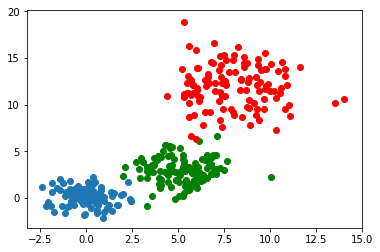

In [50]:
plt.scatter(gaus1[:, 0], gaus1[:, 1])
plt.scatter(gaus2[:, 0], gaus2[:, 1], c = "green")
plt.scatter(gaus3[:, 0], gaus3[:, 1], c = "red")
plt.show()